<a href="https://colab.research.google.com/github/inforeqd512/QLearning/blob/main/RL_Move_thru_Rooms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import numpy as np
import pylab as plt

# Task

A robot can be put in any room. It needs to try and get outside (location 5) in the shortest steps. Will solve this using **Q-learning**.

[Gridworld](https://www.mathworks.com/help/reinforcement-learning/ug/create-custom-grid-world-environments.html) is canonical example for understanding the state transitions. One can refer to it to map the grids directly to states and transitional probaliites are easy to compute.  


The aim for choosing this example over gridworld is to understand how to visualise states for problems different from typical gridworld. This example is real world yet with finite states. From this we have to derive the representation of states that can help in programming. This way I aim to get a good feel of how the problem can be converted to a markov chain, extract Transitional probabilities and understand state transitions. Then learn how can Q-learning be applied to it. 

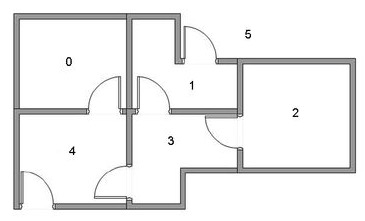

# Markov Chain
Represent the markov chain as a graph. With room as nodes in a graph. The doors connecting the rooms as edges. Add circular loop to goal room point to represent it as a terminating step. 

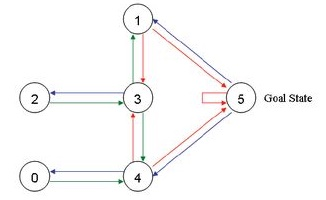

In [50]:
#graph connections
points_connection_list = [(0,4), (4,3), (4,5), (2,3), (3,1), (1,5), (5,5)]

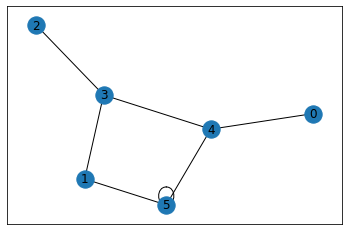

In [51]:
#visualise the graph
import networkx as nx
G = nx.Graph()
G.add_edges_from(points_connection_list)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos)
nx.draw_networkx_edges(G,pos)
nx.draw_networkx_labels(G,pos)
plt.show()


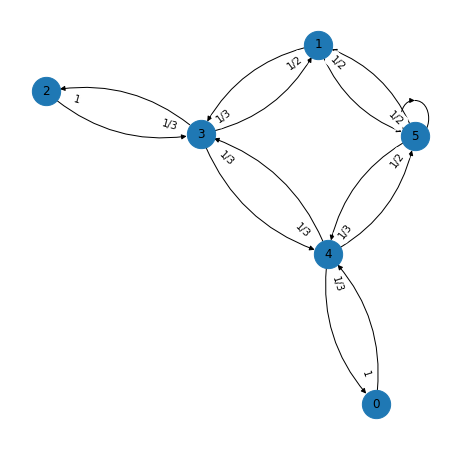

In [52]:
#visualise the graph with transition probabilities
import networkx as nx
import pylab as plt

plt.figure(figsize=(8,8))

G = nx.DiGraph()
edge_labels = {(0,4) : "1", (4,0): "1/3", (4,3): "1/3", (4,5): "1/3", (3,2): "1/3", (3,1): "1/3", (3,4): "1/3", (2,3): "1", (1,3): "1/2", (1,5): "1/2", (5,1): "1/2", (5,4): "1/2", (5,5): "1"}
directed_points_connection_list = [(0,4), (4,0), (4,3), (3,4), (4,5), (5,4), (2,3), (3,2), (3,1), (1,3), (1,5), (5,1), (5,5)]
G.add_edges_from(directed_points_connection_list)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos)
# nx.draw_networkx_edges(G,pos)
nx.draw_networkx_labels(G,pos)
nx.draw_networkx_edge_labels(G, pos, edge_labels, label_pos=0.80, font_size=10)
nx.draw(G, pos, connectionstyle='arc3, rad = 0.25',node_size=800)
plt.show()

In [53]:
#goal : final room to reach is 5 == outside
goal = 5

In [54]:
# how many points in graph? x points
MATRIX_SIZE = 6

In [55]:
# create Reward matrix = x*x
# rows represent the node for the current room in which the robot is in
# columns represent the node for the next room that the robot can go into from the current room
# initialise to -1 as if no rooms were connected
R = np.matrix(np.ones(shape=(MATRIX_SIZE, MATRIX_SIZE)))
R *= -1
R

matrix([[-1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1.]])

In [56]:
# Update Reward matrix : assign zeros to viable paths and 100 to goal-reaching connections
for point in points_connection_list:
  print(point)
  if point[1] == goal:
    R[point] = 100
  else:
    R[point] = 0

  if point[0] == goal:
    R[point[::-1]] = 100
  else:
    R[point[::-1]] = 0

R[goal, goal] = 100

R


(0, 4)
(4, 3)
(4, 5)
(2, 3)
(3, 1)
(1, 5)
(5, 5)


matrix([[ -1.,  -1.,  -1.,  -1.,   0.,  -1.],
        [ -1.,  -1.,  -1.,   0.,  -1., 100.],
        [ -1.,  -1.,  -1.,   0.,  -1.,  -1.],
        [ -1.,   0.,   0.,  -1.,   0.,  -1.],
        [  0.,  -1.,  -1.,   0.,  -1., 100.],
        [ -1.,   0.,  -1.,  -1.,   0., 100.]])

# Q-learning

In [57]:
#Q-table depending on the current room, the table keeps the value of going to the connecting room in the quest for getting to the outside
Q = np.matrix(np.zeros([MATRIX_SIZE, MATRIX_SIZE]))
Q

matrix([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])

In [58]:
# initialising learning parameter
gamma = 0.8

In [59]:
# from reward matrix get the indexes that represent the rooms that the robot can go into from it's current room
def available_actions(state):
  current_state_row = R[state,]
  avail_actions_indexes = np.where(current_state_row >= 0)[1]
  return avail_actions_indexes


In [60]:
# randomly choose the next room the robot should go into from it's current room
def sample_next_action(avail_actions_indexes):
  next_action_index = int(np.random.choice(avail_actions_indexes, 1))
  return next_action_index


In [61]:
# update the Q-table using Temporal Difference , Bellman's optimality squation with learning rate alpha of 1 
# and return the score as total sum of percentages of value of each connection between rooms
def update(current_state, action, gamma):
  max_index = np.where(Q[action,] == np.max(Q[action,])) [1] # when the robot goes into the next room ie 'action', choose the room that holds the highest value in the quest to go to the 'goal' room

  if max_index.shape[0] > 1:
    max_index = int(np.random.choice(max_index,1))
  else:
    max_index = int(max_index)

  next_state = action
  max_value = Q[next_state, max_index]
  Q[current_state, action] = R[current_state, action] + gamma * max_value #with learning rate alpha of 1
  # print('max_value : ', R[current_state, action] + gamma * max_value)

  #compute score
  score = 0
  if np.max(Q) > 0:
    score = np.sum(Q/np.max(Q) * 100)
  else:
    score = 0
  return score


#Testing the functions

In [62]:
initial_state = 1

In [63]:
available_act = available_actions(initial_state)
available_act

array([3, 5])

In [64]:
action = sample_next_action(available_act)
action

5

In [65]:
update(initial_state, 0, gamma)

0

# Q-Learning : Training

In [66]:
scores = []
for i in range(700):
    current_state = np.random.randint(0, int(Q.shape[0]))
    available_act = available_actions(current_state)
    action = sample_next_action(available_act)
    score = update(current_state,action,gamma)
    scores.append(score)
    # print ('Score:', str(score))



In [67]:
print("Trained Q matrix:")
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
print(Q/np.max(Q)*100)

Trained Q matrix:
[[0.00 0.00 0.00 0.00 79.92 0.00]
 [-0.20 0.00 0.00 63.98 0.00 100.00]
 [0.00 0.00 0.00 63.98 0.00 0.00]
 [0.00 79.98 51.19 0.00 79.92 0.00]
 [63.94 0.00 0.00 63.98 0.00 99.91]
 [0.00 79.98 0.00 0.00 79.92 99.98]]


# Q-Learning : Testing

In [68]:

current_state = 2
steps = [current_state]

while current_state != goal:

    next_step_index = np.where(Q[current_state,] == np.max(Q[current_state,]))[1]

    if next_step_index.shape[0] > 1:
        next_step_index = int(np.random.choice(next_step_index, size = 1))
    else:
        next_step_index = int(next_step_index)

    steps.append(next_step_index)
    current_state = next_step_index

print("Most efficient path:")
print(steps)

Most efficient path:
[2, 3, 1, 5]


# How the episodes settle the Q-values

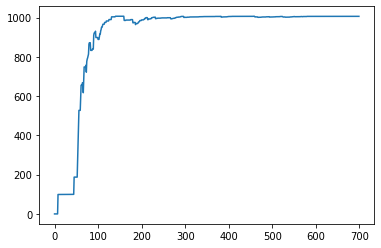

In [69]:
plt.plot(scores)
plt.show()